# Assignment 2

## Imports

In [5]:
!pip install vaderSentiment -q
!pip install umap-learn -q

In [6]:
# imports - usual suspects
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import regex as re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from umap.umap_ import UMAP

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aditya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aditya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Dataset 

In [7]:
SQL = "SELECT * from `questrom.datasets.music-app-reviews`"
YOUR_BILLING_PROJECT = "ba820-329602"
music_app_review = pd.read_gbq(SQL, YOUR_BILLING_PROJECT)

In [8]:
music_app_review.sample(3)

,review,rating
5075,not much to say about foam. They do the job w...,5
6453,Make sure you order the right size! I don't us...,5
6076,Good quality but not as nice as some pricier o...,5


## Data Cleaning

In [9]:
music_app_review.shape

(10261, 2)

In [10]:
music_app_review.duplicated().sum()

5

In [11]:
music_app_review.drop_duplicates(inplace=True)
music_app_review.duplicated().sum()

0

In [12]:
music_app_review.isna().sum()

review    2
rating    0
dtype: int64

In [13]:
music_app_review.dropna(inplace=True)
music_app_review.isna().sum()

review    0
rating    0
dtype: int64

In [14]:
music_app_review.shape

(10254, 2)

## EDA

[Text(0.5, 1.0, 'Countplot of Rating')]

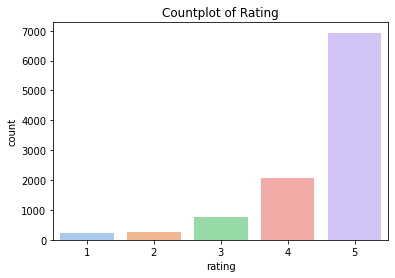

In [15]:
sns.countplot(data=music_app_review,x="rating",palette="pastel").set(title='Countplot of Rating')

### Most used words in each review.

In [16]:
df_review = music_app_review.groupby('rating').agg({'review': 'sum'}).reset_index()
df_review

,rating,review
0,1,"It hums, crackles, and I think I'm having prob..."
1,2,I bought this to use with my keyboard. I wasn'...
2,3,I now use this cable to run from the output of...
3,4,I got it to have it if I needed it. I have fou...
4,5,"Not much to write about here, but it does exac..."


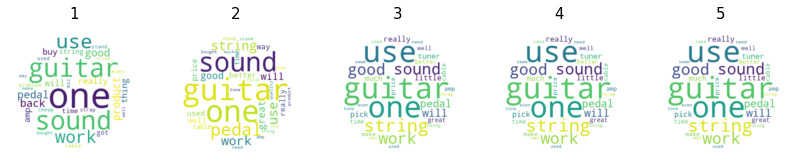

In [17]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=[14, 14], facecolor = None)

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc1 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc1.generate(df_review['review'][0])

ax1.axis("off")
ax1.imshow(wc1, interpolation="bilinear")
ax1.set_title(df_review['rating'][0],fontsize=15)


wc2 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc2.generate(df_review['review'][1])

ax2.axis("off")
ax2.imshow(wc2, interpolation="bilinear")
ax2.set_title(df_review['rating'][1],fontsize=15);


wc3 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc3.generate(df_review['review'][2])

ax3.axis("off")
ax3.imshow(wc3, interpolation="bilinear")
ax3.set_title(df_review['rating'][2],fontsize=15)


wc4 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc4.generate(df_review['review'][3])

ax4.axis("off")
ax4.imshow(wc3, interpolation="bilinear")
ax4.set_title(df_review['rating'][3],fontsize=15)



wc5 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc5.generate(df_review['review'][4])

ax5.axis("off")
ax5.imshow(wc3, interpolation="bilinear")
ax5.set_title(df_review['rating'][4],fontsize=15)

plt.show()

## Data preprocessing

### Sentiment-Analysis

In [18]:
## Creating sentimental polarity 
analyzer = SentimentIntensityAnalyzer()
def compound_score(txt):
    return analyzer.polarity_scores(txt)["compound"]

## Sentiments
def sentiment(score):
    emotion = ""
    if score >= 0.5:
        emotion = "Positive"
    elif score <= -0.5:
        emotion = "Negative"
    else:
        emotion = "Neutral"
    return emotion

In [19]:
## Applying Compund score
polarity_scores = music_app_review["review"].astype("str").apply(compound_score)
music_app_review["Sentiment_Score"] = polarity_scores

## Applying Sentiment
music_app_review["Sentiment"] = music_app_review["Sentiment_Score"].apply(sentiment)

In [20]:
music_app_review

,review,rating,Sentiment_Score,Sentiment
0,"It hums, crackles, and I think I'm having prob...",1,-0.4049,Neutral
1,I'm a pro-cheapo and I hated this thing. They'...,1,-0.8203,Negative
2,"Received it in time, standard blister packagin...",1,-0.6310,Negative
3,These things are terrible. One wouldn't fit in...,1,-0.7789,Negative
4,This is a cheap piece of junk that does what i...,1,0.8619,Positive
...,...,...,...,...
10256,True to phosphor bronze these strings have a m...,5,0.8201,Positive
10257,I've used Elixirs for about five years now. Th...,5,0.9848,Positive
10258,I really like these strings. While they are n...,5,0.9589,Positive
10259,"Great, just as expected. Thank to all.",5,0.7650,Positive


[Text(0.5, 1.0, 'Countplot of Sentiment')]

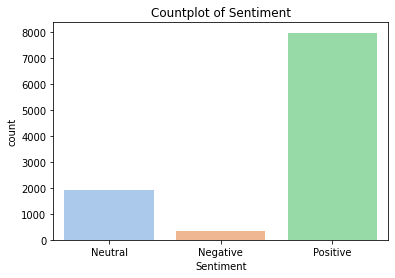

In [21]:
sns.countplot(data=music_app_review,x="Sentiment",palette="pastel").set(title='Countplot of Sentiment')

In [22]:
# Preparing data for visualization 
Viz_1 = music_app_review[['rating','Sentiment']].value_counts().rename_axis(['Rating','Sentiment']).reset_index(name='counts')

# Plotting the Bar Graph 
fig = px.bar(x=Viz_1.Rating, y=Viz_1.counts, color=Viz_1.Sentiment,color_discrete_sequence=px.colors.qualitative.Pastel,title="Sentiment & Ratings",labels={'x':'Ratings','y':'Total Number'})
fig.show()

In [23]:
df_sentiment_review = music_app_review.groupby('Sentiment').agg({'review': 'sum'}).reset_index()
df_sentiment_review

,Sentiment,review
0,Negative,I'm a pro-cheapo and I hated this thing. They'...
1,Neutral,"It hums, crackles, and I think I'm having prob..."
2,Positive,This is a cheap piece of junk that does what i...


In [24]:
stops = set(stopwords.words("english"))
def clean_content(text):
    #Converting text to lowercase characters
    text = text.lower()
    #Removing HTML tags
    text = re.sub(r'\<[^<>]*\>','', text) 
    #Removing any character which does not match to letter,digit or underscore
    text = re.sub(r'^\W+|\W+$',' ', text)
    #Removing space,newline,tab
    text = re.sub(r'\s',' ',text)
    #Removing punctuation
    text = re.sub(r'[^a-zA-Z0-9]',' ',text)
    # Remove any numbers
    text = re.sub(r'[0-9]+', '', text)
    #Tokenizing data
    text = word_tokenize(text)
    #Removing stopwords
    text = [i for i in text if i not in stops]
    return(text)

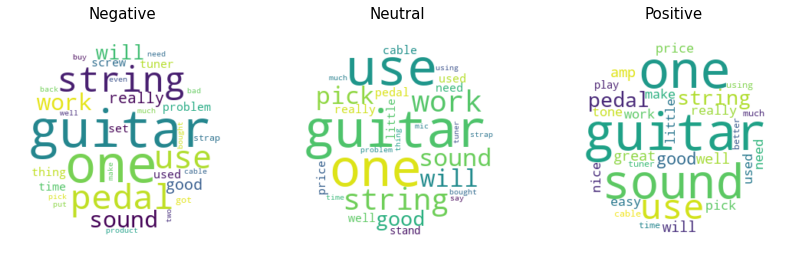

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[14, 14], facecolor = None)

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc1 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc1.generate(df_sentiment_review['review'][0])

ax1.axis("off")
ax1.imshow(wc1, interpolation="bilinear")
ax1.set_title(df_sentiment_review['Sentiment'][0],fontsize=15)


wc2 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc2.generate(df_sentiment_review['review'][1])

ax2.axis("off")
ax2.imshow(wc2, interpolation="bilinear")
ax2.set_title(df_sentiment_review['Sentiment'][1],fontsize=15);


wc3 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc3.generate(df_sentiment_review['review'][2])

ax3.axis("off")
ax3.imshow(wc3, interpolation="bilinear")
ax3.set_title(df_sentiment_review['Sentiment'][2],fontsize=15)

plt.show()

In [26]:
df_sentiment_review['review'] = df_sentiment_review['review'].apply(lambda x: clean_content(x))

In [27]:
for i in range(len(df_sentiment_review)):
    print(df_sentiment_review['Sentiment'][i])
    words = df_sentiment_review['review'][i]
    most_common_words= [word for word, word_count in Counter(words).most_common(100)]
    print(most_common_words)

Negative
['guitar', 'one', 'get', 'strings', 'use', 'like', 'pedal', 'would', 'really', 'sound', 'good', 'strap', 'used', 'string', 'time', 'much', 'got', 'bad', 'could', 'even', 'bought', 'buy', 'back', 'put', 'well', 'first', 'thing', 'problem', 'work', 'two', 'product', 'need', 'set', 'also', 'quality', 'new', 'amp', 'tuner', 'cheap', 'price', 'way', 'mic', 'great', 'go', 'little', 'stand', 'works', 'another', 'using', 'fit', 'know', 'make', 'better', 'tone', 'years', 'case', 'screws', 'right', 'tried', 'say', 'pedals', 'fine', 'still', 'power', 'cable', 'picks', 'long', 'enough', 'since', 'e', 'playing', 'feel', 'hold', 'many', 'guitars', 'hard', 'turn', 'bit', 'though', 'however', 'clip', 'volume', 'never', 'broke', 'drop', 'sure', 'want', 'around', 'find', 'screw', 'metal', 'see', 'pick', 'switch', 'battery', 'small', 'review', 'acoustic', 'last', 'made']
Neutral
['guitar', 'one', 'use', 'like', 'strings', 'good', 'well', 'get', 'sound', 'would', 'works', 'little', 'really', 'ped

## Prediction Model

In [28]:
snowball = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

In [29]:
def tokenize(text):
    return [snowball.stem(word) for word in tokenizer.tokenize(text.lower())]

In [30]:
tfidf = TfidfVectorizer(stop_words = 'english', tokenizer = tokenize)
idf = tfidf.fit_transform(music_app_review['review'])
idf = pd.DataFrame(idf.toarray(), columns=tfidf.get_feature_names_out())

C:\ProgramData\Anaconda3\envs\ba820\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.



In [31]:
umap = UMAP(2)
u2 = umap.fit_transform(idf)
u2df = pd.DataFrame(u2, columns=["e1", "e2"])
u2df.reset_index(inplace=True)

C:\ProgramData\Anaconda3\envs\ba820\lib\site-packages\umap\spectral.py:260: UserWarning:

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!



In [32]:
prediction_dataset = music_app_review.copy()
prediction_dataset.reset_index(drop=True, inplace=True)
prediction_dataset["e1"] = u2df["e1"]
prediction_dataset["e2"] = u2df["e2"]

In [33]:
prediction_dataset.drop(["review","Sentiment"], axis=1, inplace=True)
prediction_dataset

,rating,Sentiment_Score,e1,e2
0,1,-0.4049,-6.474681,2.432189
1,1,-0.8203,-5.454442,0.053658
2,1,-0.6310,-1.293769,5.656044
3,1,-0.7789,-2.765644,-4.732392
4,1,0.8619,1.810176,15.543105
...,...,...,...,...
10249,5,0.8201,10.759751,11.606848
10250,5,0.9848,14.451665,10.483176
10251,5,0.9589,11.811710,15.081766
10252,5,0.7650,8.535714,-2.397192


In [34]:
steps = [ ("scale", MinMaxScaler()),
    ('model', xgb.XGBClassifier())]

param_grid = {
    'model__max_depth': [2, 3, 5, 7, 10],
    'model__n_estimators': [10, 100, 500],
}

pipe = Pipeline(steps)

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

In [35]:
X = prediction_dataset.drop('rating', axis=1)  
y = prediction_dataset['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=8)

In [36]:
grid.fit(X_train, y_train)

C:\ProgramData\Anaconda3\envs\ba820\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:50:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                           

In [37]:
y_hat = grid.predict(X_test)
accuracy = accuracy_score(y_hat, y_test)
accuracy

0.6693262411347518